In [14]:
import os
import time
# import data handling tools
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, GlobalAveragePooling2D
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [15]:
class EyeDiseaseDataset:
    def __init__(self, dataDir):
        self.data_dir = dataDir
   
    def dataPaths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldPath = os.path.join(self.data_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels
  
    def dataFrame(self, files, labels):

        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)
   
    def split_(self):
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)
        strat = df['labels']
        trainData, dummyData = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)
        strat = dummyData['labels']
        validData, testData = train_test_split(dummyData, train_size=0.5, shuffle=True, random_state=42, stratify=strat)
        return trainData, validData, testData

In [16]:
dataDir=r"C:\Users\shavy\OneDrive\Desktop\AICraft\archive (13)\dataset"

In [17]:
dataSplit = EyeDiseaseDataset(dataDir)
train_data, valid_data, test_data = dataSplit.split_()

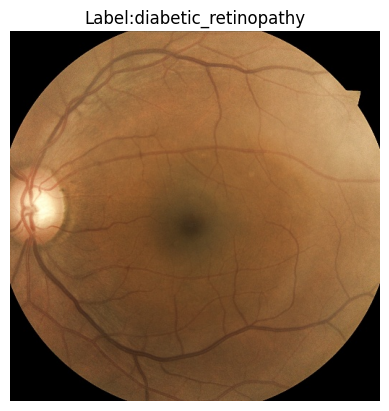

In [18]:
def display_random_image(df):
    random_row = df.sample(1).iloc[0]
    filepath = random_row['filepaths']
    label = random_row['labels']
    
    img = Image.open(filepath)
    plt.imshow(img)
    plt.title(f'Label:{label}')
    plt.axis('off')
    plt.show()

display_random_image(train_data)

In [19]:
def augment_data( train_df, valid_df, test_df, batch_size=16):

    img_size = (256,256)
    channels = 3
    color = 'rgb'
    

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
              rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              brightness_range=[0.5, 1.5])
          
    valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
          
    train_generator = train_datagen.flow_from_dataframe(
              train_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )
   
    print("Shape of augmented training images:", train_generator.image_shape)
          
    valid_generator = valid_test_datagen.flow_from_dataframe(
              valid_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )
         
    print("Shape of validation images:", valid_generator.image_shape)
          
    test_generator = valid_test_datagen.flow_from_dataframe(
              test_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=False,
              class_mode='categorical'
          )
          
    print("Shape of test images:", test_generator.image_shape)
          
    return train_generator, valid_generator, test_generator

In [20]:
train_augmented, valid_augmented, test_augmented = augment_data(train_data, valid_data, test_data)

Found 3373 validated image filenames belonging to 4 classes.
Shape of augmented training images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of validation images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of test images: (256, 256, 3)


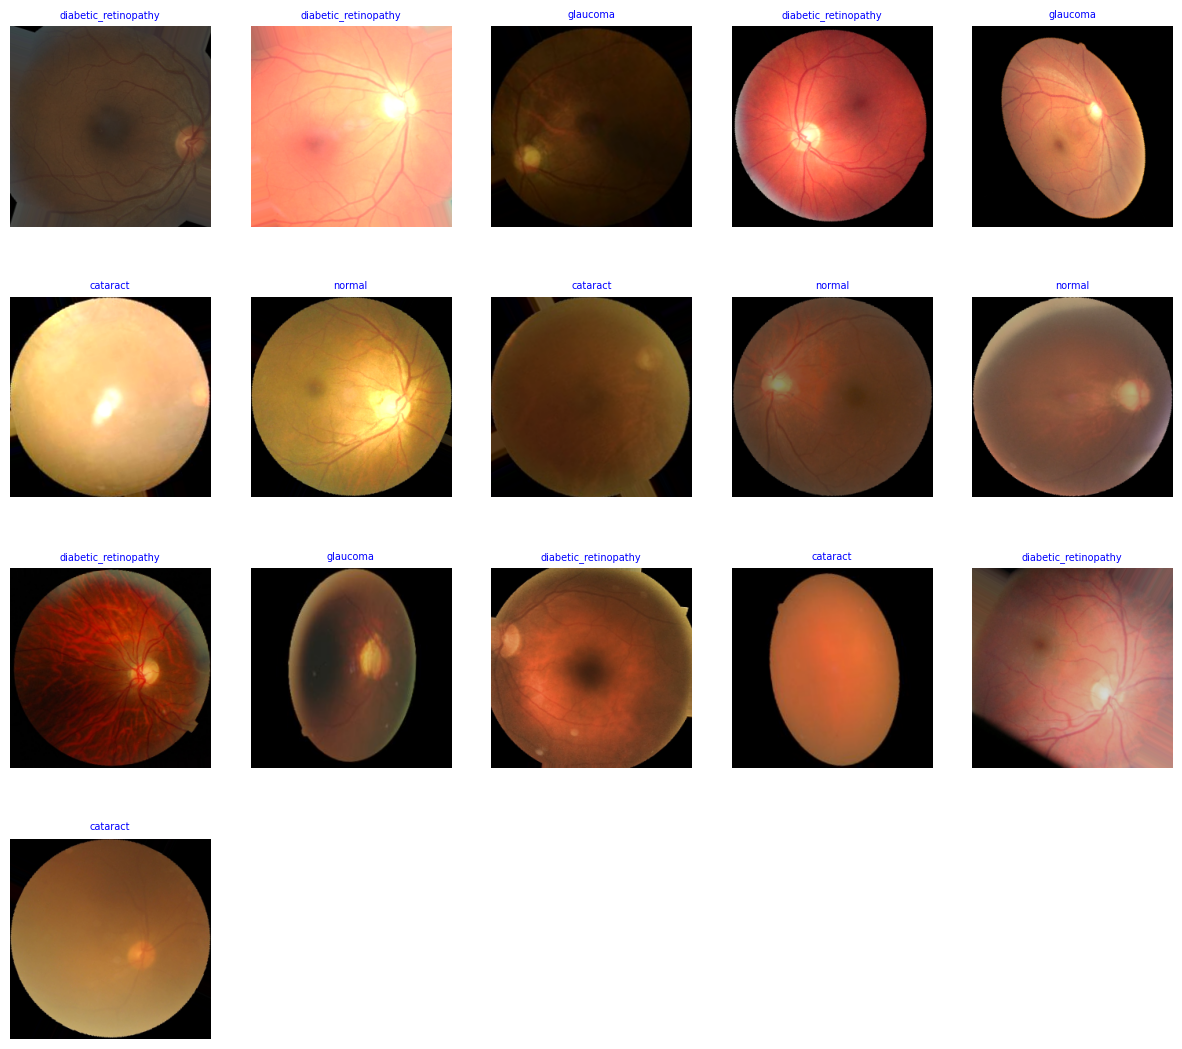

In [21]:
def show_images(gen):
      
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator
    length = len(labels)       
    sample = min(length, 20)   
    plt.figure(figsize= (15, 17))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255      
        plt.imshow(image)
        index = np.argmax(labels[i])  
        class_name = classes[index]  
        plt.title(class_name, color= 'blue', fontsize= 7 )
        plt.axis('off')
    plt.show()
show_images(train_augmented)

In [22]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import regularizers

classes = len(list(train_augmented.class_indices.keys()))

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu' , kernel_regularizer = regularizers.l2(0.01))(x)

predictions = Dense(classes, activation='softmax', kernel_regularizer = regularizers.l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [24]:
history = model.fit(
    train_augmented,
    epochs=15, 
    validation_data=valid_augmented,
    )

Epoch 1/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 186s 879ms/step - accuracy: 0.7956 - loss: 0.6963 - val_accuracy: 0.7891 - val_loss: 0.7710
Epoch 2/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 187s 885ms/step - accuracy: 0.7951 - loss: 0.6658 - val_accuracy: 0.7607 - val_loss: 0.7482
Epoch 3/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 181s 858ms/step - accuracy: 0.7821 - loss: 0.7012 - val_accuracy: 0.7773 - val_loss: 0.7776
Epoch 4/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 182s 864ms/step - accuracy: 0.8057 - loss: 0.6656 - val_accuracy: 0.7393 - val_loss: 0.7965
Epoch 5/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 180s 855ms/step - accuracy: 0.7956 - loss: 0.6826 - val_accuracy: 0.7725 - val_loss: 0.7590
Epoch 6/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.8006 - loss: 0.6571 - val_accuracy: 0.8436 - val_loss: 0.6456
Epoch 7/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 180s 851ms/step - accuracy: 0.8181 - loss: 0.6175 - val_accuracy: 0.7773 - val_loss: 0.7242
Epoch 8/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 180s 852ms/step - accuracy: 0.8055 - lo

Training Accuracy: 0.8268603682518005
Validation Accuracy: 0.7748815417289734


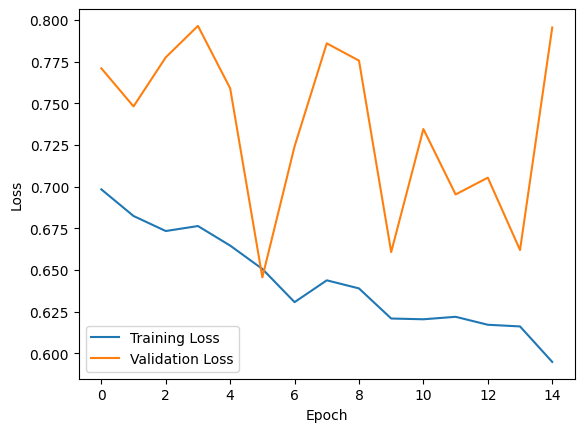

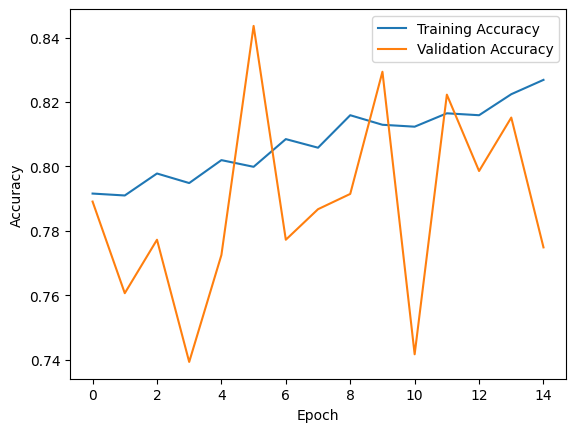

In [25]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


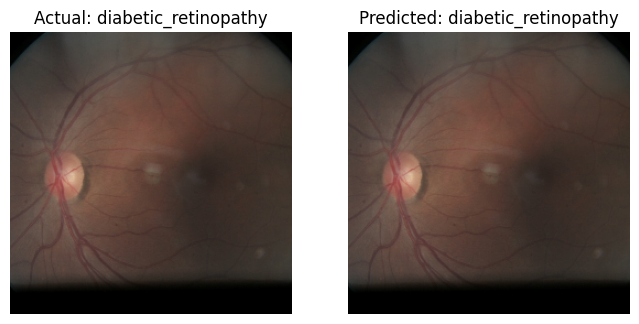

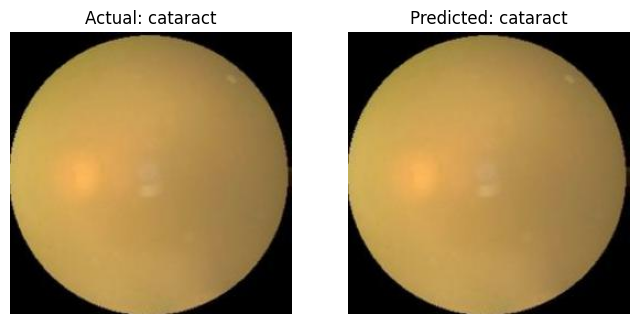

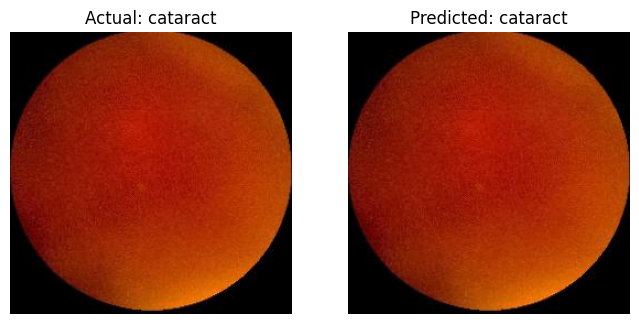

In [28]:
def plot_actual_vs_predicted(model, test_data, num_samples=3):
    
    # Get a batch of test data
    test_images, test_labels = next(iter(test_data))

    predictions = model.predict(test_images)

    class_labels = list(train_augmented.class_indices.keys())

    sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
      # Plot the images with actual and predicted labels
    for i in sample_indices:
        actual_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
plot_actual_vs_predicted(model, test_augmented)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


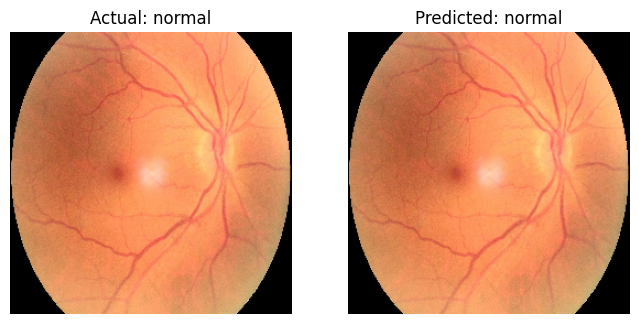

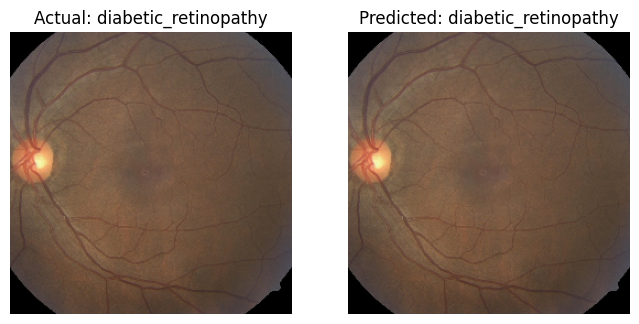

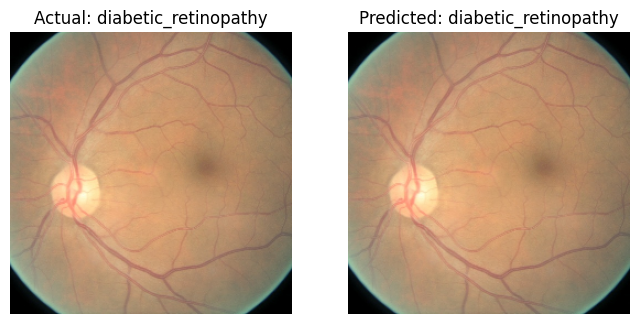

In [29]:
def plot_actual_vs_predicted(model, test_data, num_samples=3):
    
    # Get a batch of test data
    test_images, test_labels = next(iter(test_data))

    predictions = model.predict(test_images)

    class_labels = list(train_augmented.class_indices.keys())

    sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
      # Plot the images with actual and predicted labels
    for i in sample_indices:
        actual_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
plot_actual_vs_predicted(model, test_augmented)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


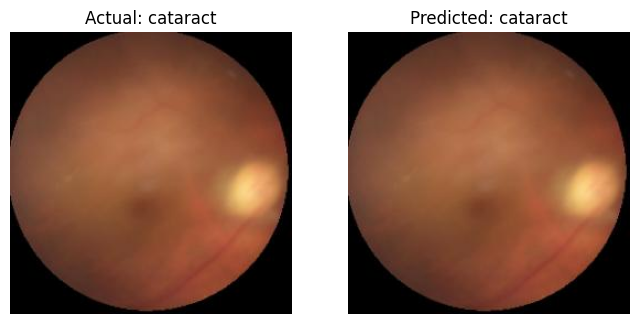

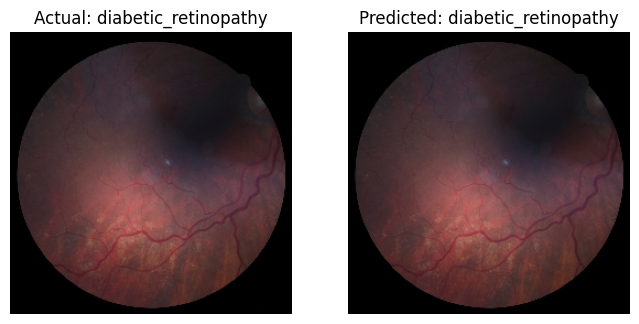

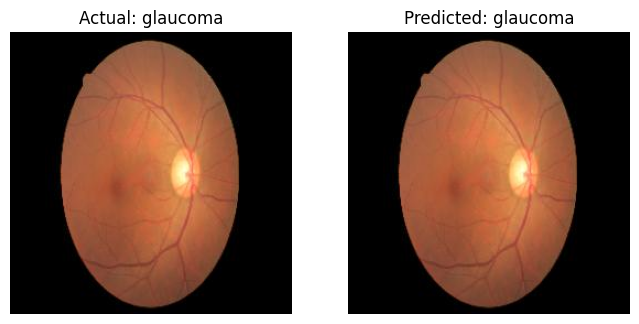

In [30]:
def plot_actual_vs_predicted(model, test_data, num_samples=3):
    
    # Get a batch of test data
    test_images, test_labels = next(iter(test_data))

    predictions = model.predict(test_images)

    class_labels = list(train_augmented.class_indices.keys())

    sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
      # Plot the images with actual and predicted labels
    for i in sample_indices:
        actual_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
plot_actual_vs_predicted(model, test_augmented)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


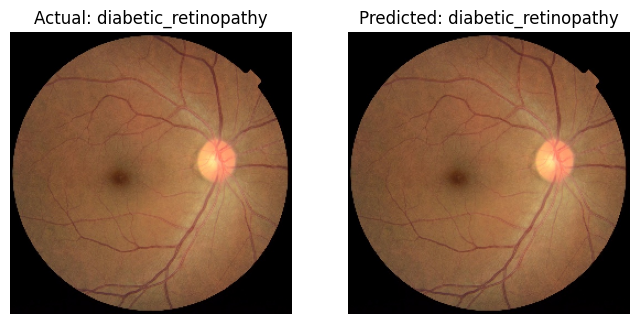

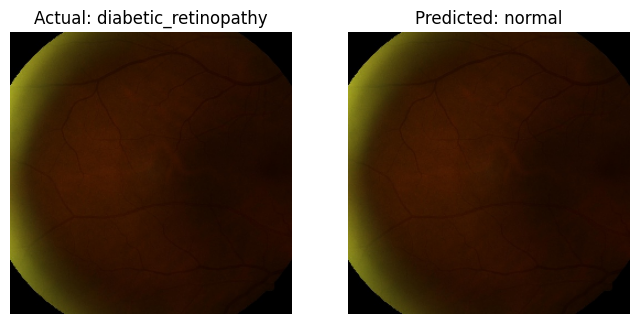

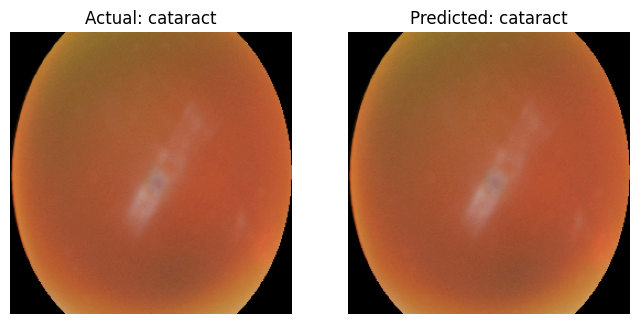

In [31]:
def plot_actual_vs_predicted(model, test_data, num_samples=3):
    
    # Get a batch of test data
    test_images, test_labels = next(iter(test_data))

    predictions = model.predict(test_images)

    class_labels = list(train_augmented.class_indices.keys())

    sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
      # Plot the images with actual and predicted labels
    for i in sample_indices:
        actual_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
plot_actual_vs_predicted(model, test_augmented)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


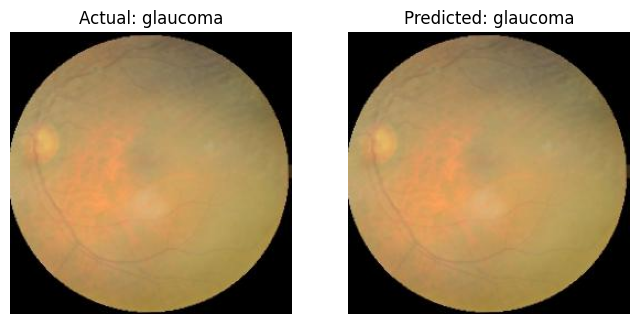

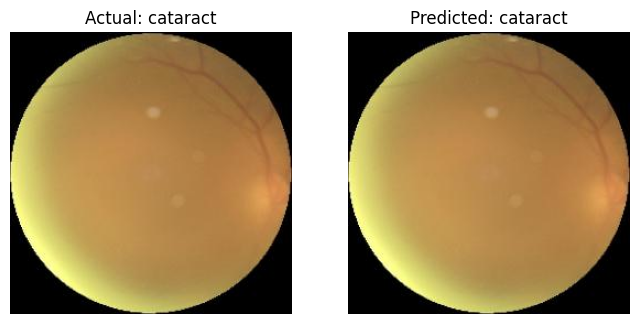

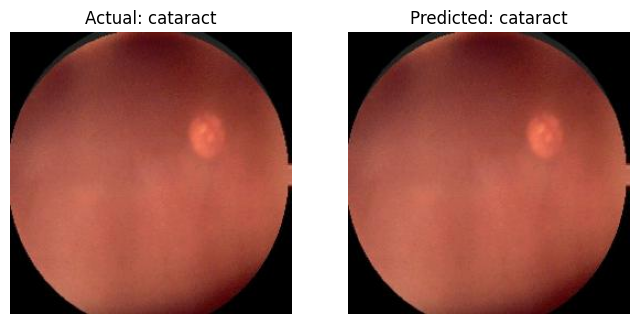

In [32]:
def plot_actual_vs_predicted(model, test_data, num_samples=3):
    
    # Get a batch of test data
    test_images, test_labels = next(iter(test_data))

    predictions = model.predict(test_images)

    class_labels = list(train_augmented.class_indices.keys())

    sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
      # Plot the images with actual and predicted labels
    for i in sample_indices:
        actual_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
plot_actual_vs_predicted(model, test_augmented)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


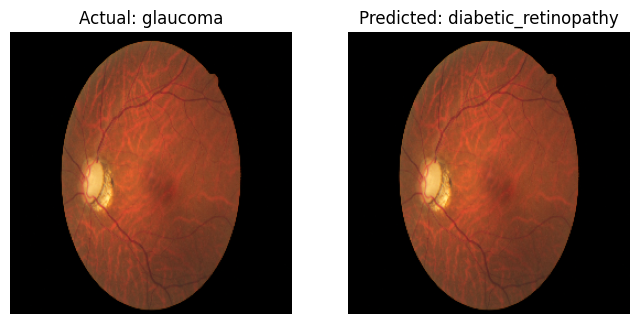

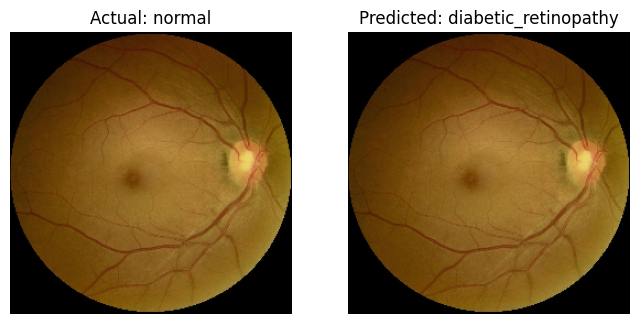

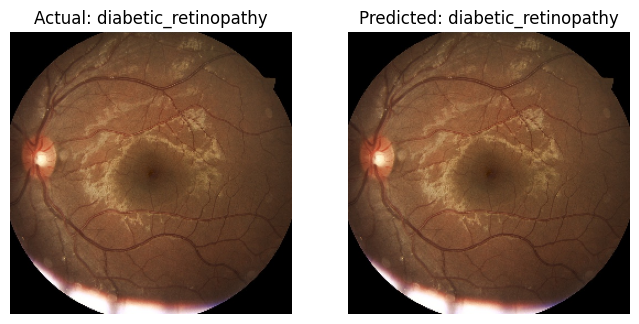

In [33]:
def plot_actual_vs_predicted(model, test_data, num_samples=3):
    
    # Get a batch of test data
    test_images, test_labels = next(iter(test_data))

    predictions = model.predict(test_images)

    class_labels = list(train_augmented.class_indices.keys())

    sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
      # Plot the images with actual and predicted labels
    for i in sample_indices:
        actual_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
plot_actual_vs_predicted(model, test_augmented)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


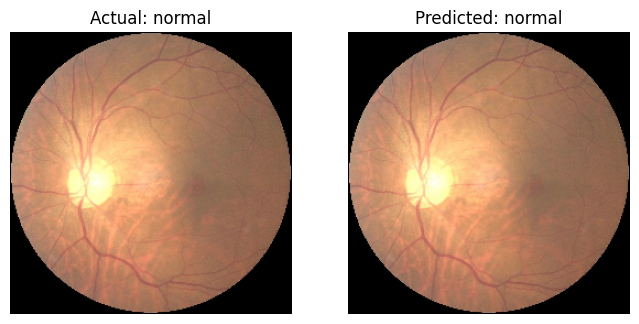

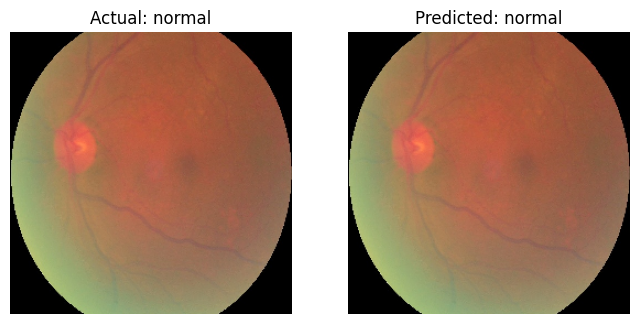

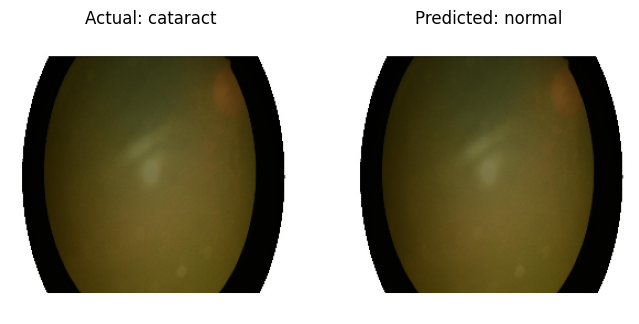

In [34]:
def plot_actual_vs_predicted(model, test_data, num_samples=3):
    
    # Get a batch of test data
    test_images, test_labels = next(iter(test_data))

    predictions = model.predict(test_images)

    class_labels = list(train_augmented.class_indices.keys())

    sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
      # Plot the images with actual and predicted labels
    for i in sample_indices:
        actual_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
plot_actual_vs_predicted(model, test_augmented)

NameError: name 'y_pred' is not defined

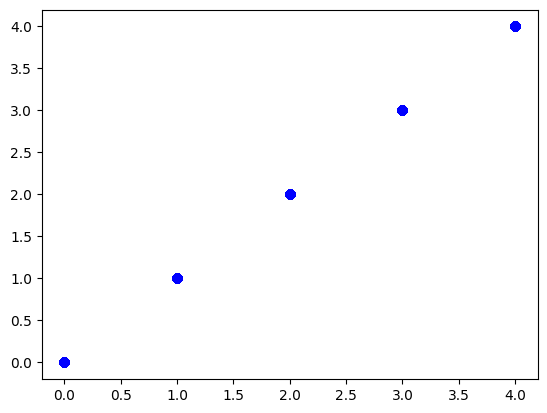

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your model is a linear regression model
# X: Feature values (input data)
# y: True labels (target)
# y_pred: Predicted values from the model

# Scatter plot of the true data points
plt.scatter(X, y, color='blue', label='True Data')

# Plot the regression line
plt.plot(X, y_pred, color='red', label='Regression Line')

# Adding labels and title
plt.xlabel('X values')
plt.ylabel('y values')
plt.title('Linear Regression Model')

# Show legend
plt.legend()

# Display the plot
plt.show()


In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_data(train_data, valid_data, test_data):
    # Define the ImageDataGenerator for augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize the images
        rotation_range=20,  # Random rotations
        width_shift_range=0.2,  # Horizontal shifts
        height_shift_range=0.2,  # Vertical shifts
        shear_range=0.2,  # Shear transformations
        zoom_range=0.2,  # Zoom transformations
        horizontal_flip=True,  # Random horizontal flips
        fill_mode='nearest'  # How to fill in newly created pixels
    )

    valid_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation data
    test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for test data

    # Apply the transformations to the data
    train_augmented = train_datagen.flow_from_directory(
        train_data, 
        target_size=(256, 256), 
        batch_size=32, 
        class_mode='categorical'
    )

    valid_augmented = valid_datagen.flow_from_directory(
        valid_data, 
        target_size=(256, 256), 
        batch_size=32, 
        class_mode='categorical'
    )

    test_augmented = test_datagen.flow_from_directory(
        test_data, 
        target_size=(256, 256), 
        batch_size=32, 
        class_mode='categorical'
    )

    return train_augmented, valid_augmented, test_augmented


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..242.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [51.0..243.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


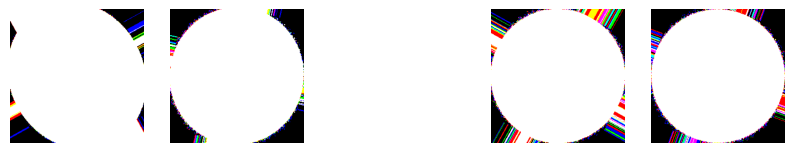

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot augmented images
def plot_augmented_images(generator, num_images=5):
    # Get a batch of images
    images, labels = next(generator)
    
    # Plot a few augmented images
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

# Call the function to plot augmented images
plot_augmented_images(train_augmented, num_images=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..173.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


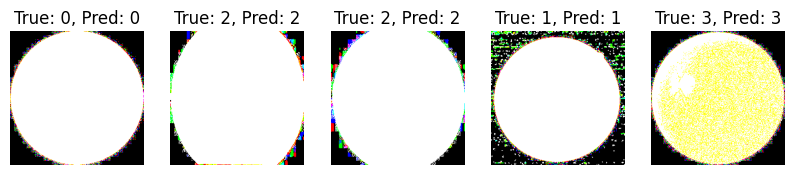

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot predictions
def plot_predictions(model, generator, num_images=5):
    # Get a batch of images and their true labels
    images, labels = next(generator)
    
    # Make predictions on the images
    predictions = model.predict(images)
    
    # Plot a few images with their predicted and true labels
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(f"True: {np.argmax(labels[i])}, Pred: {np.argmax(predictions[i])}")
        plt.axis('off')
    plt.show()

# Call the function to plot predictions
plot_predictions(model, test_augmented, num_images=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


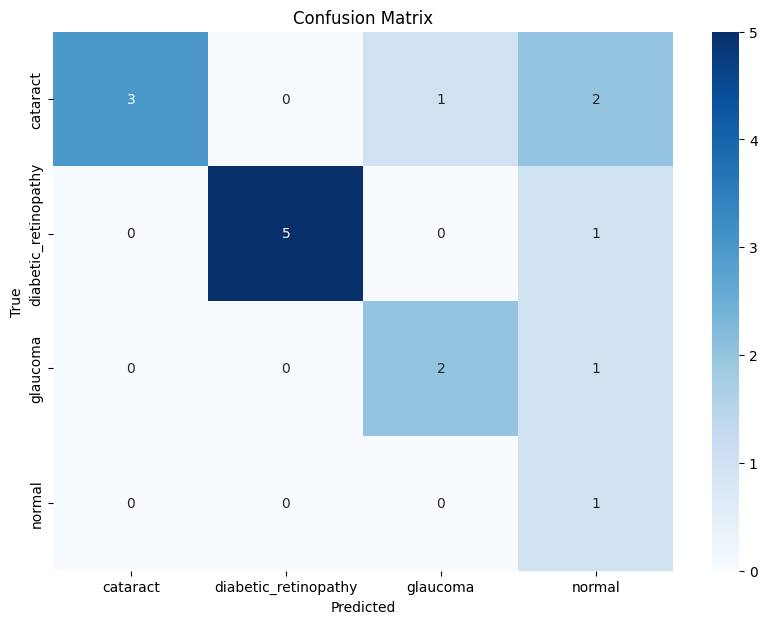

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions and true labels
y_true = []
y_pred = []

for images, labels in test_augmented:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))  # Get true labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Get predicted labels
    break  # Just one batch

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_augmented.class_indices.keys(), yticklabels=train_augmented.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [43]:
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Select the layer you want to visualize
layer_name = 'conv2d'  # Replace with the name of the layer you want to visualize
layer = model.get_layer(name=layer_name)

# Create a model that outputs the activations of the selected layer
activation_model = Model(inputs=model.input, outputs=layer.output)

# Pick an image from the test set to visualize
image, label = next(iter(test_augmented))  # Get a batch
image_to_visualize = image[0]  # Pick the first image in the batch

# Get the activations
activations = activation_model.predict(np.expand_dims(image_to_visualize, axis=0))

# Plot the feature maps
num_filters = activations.shape[-1]
fig, axes = plt.subplots(1, num_filters, figsize=(20, 20))

for i in range(num_filters):
    axes[i].imshow(activations[0, :, :, i], cmap='viridis')
    axes[i].axis('off')

plt.show()


ValueError: No such layer: conv2d. Existing layers are: ['input_layer', 'rescaling', 'normalization', 'rescaling_1', 'stem_conv_pad', 'stem_conv', 'stem_bn', 'stem_activation', 'block1a_dwconv', 'block1a_bn', 'block1a_activation', 'block1a_se_squeeze', 'block1a_se_reshape', 'block1a_se_reduce', 'block1a_se_expand', 'block1a_se_excite', 'block1a_project_conv', 'block1a_project_bn', 'block1b_dwconv', 'block1b_bn', 'block1b_activation', 'block1b_se_squeeze', 'block1b_se_reshape', 'block1b_se_reduce', 'block1b_se_expand', 'block1b_se_excite', 'block1b_project_conv', 'block1b_project_bn', 'block1b_drop', 'block1b_add', 'block2a_expand_conv', 'block2a_expand_bn', 'block2a_expand_activation', 'block2a_dwconv_pad', 'block2a_dwconv', 'block2a_bn', 'block2a_activation', 'block2a_se_squeeze', 'block2a_se_reshape', 'block2a_se_reduce', 'block2a_se_expand', 'block2a_se_excite', 'block2a_project_conv', 'block2a_project_bn', 'block2b_expand_conv', 'block2b_expand_bn', 'block2b_expand_activation', 'block2b_dwconv', 'block2b_bn', 'block2b_activation', 'block2b_se_squeeze', 'block2b_se_reshape', 'block2b_se_reduce', 'block2b_se_expand', 'block2b_se_excite', 'block2b_project_conv', 'block2b_project_bn', 'block2b_drop', 'block2b_add', 'block2c_expand_conv', 'block2c_expand_bn', 'block2c_expand_activation', 'block2c_dwconv', 'block2c_bn', 'block2c_activation', 'block2c_se_squeeze', 'block2c_se_reshape', 'block2c_se_reduce', 'block2c_se_expand', 'block2c_se_excite', 'block2c_project_conv', 'block2c_project_bn', 'block2c_drop', 'block2c_add', 'block3a_expand_conv', 'block3a_expand_bn', 'block3a_expand_activation', 'block3a_dwconv_pad', 'block3a_dwconv', 'block3a_bn', 'block3a_activation', 'block3a_se_squeeze', 'block3a_se_reshape', 'block3a_se_reduce', 'block3a_se_expand', 'block3a_se_excite', 'block3a_project_conv', 'block3a_project_bn', 'block3b_expand_conv', 'block3b_expand_bn', 'block3b_expand_activation', 'block3b_dwconv', 'block3b_bn', 'block3b_activation', 'block3b_se_squeeze', 'block3b_se_reshape', 'block3b_se_reduce', 'block3b_se_expand', 'block3b_se_excite', 'block3b_project_conv', 'block3b_project_bn', 'block3b_drop', 'block3b_add', 'block3c_expand_conv', 'block3c_expand_bn', 'block3c_expand_activation', 'block3c_dwconv', 'block3c_bn', 'block3c_activation', 'block3c_se_squeeze', 'block3c_se_reshape', 'block3c_se_reduce', 'block3c_se_expand', 'block3c_se_excite', 'block3c_project_conv', 'block3c_project_bn', 'block3c_drop', 'block3c_add', 'block4a_expand_conv', 'block4a_expand_bn', 'block4a_expand_activation', 'block4a_dwconv_pad', 'block4a_dwconv', 'block4a_bn', 'block4a_activation', 'block4a_se_squeeze', 'block4a_se_reshape', 'block4a_se_reduce', 'block4a_se_expand', 'block4a_se_excite', 'block4a_project_conv', 'block4a_project_bn', 'block4b_expand_conv', 'block4b_expand_bn', 'block4b_expand_activation', 'block4b_dwconv', 'block4b_bn', 'block4b_activation', 'block4b_se_squeeze', 'block4b_se_reshape', 'block4b_se_reduce', 'block4b_se_expand', 'block4b_se_excite', 'block4b_project_conv', 'block4b_project_bn', 'block4b_drop', 'block4b_add', 'block4c_expand_conv', 'block4c_expand_bn', 'block4c_expand_activation', 'block4c_dwconv', 'block4c_bn', 'block4c_activation', 'block4c_se_squeeze', 'block4c_se_reshape', 'block4c_se_reduce', 'block4c_se_expand', 'block4c_se_excite', 'block4c_project_conv', 'block4c_project_bn', 'block4c_drop', 'block4c_add', 'block4d_expand_conv', 'block4d_expand_bn', 'block4d_expand_activation', 'block4d_dwconv', 'block4d_bn', 'block4d_activation', 'block4d_se_squeeze', 'block4d_se_reshape', 'block4d_se_reduce', 'block4d_se_expand', 'block4d_se_excite', 'block4d_project_conv', 'block4d_project_bn', 'block4d_drop', 'block4d_add', 'block4e_expand_conv', 'block4e_expand_bn', 'block4e_expand_activation', 'block4e_dwconv', 'block4e_bn', 'block4e_activation', 'block4e_se_squeeze', 'block4e_se_reshape', 'block4e_se_reduce', 'block4e_se_expand', 'block4e_se_excite', 'block4e_project_conv', 'block4e_project_bn', 'block4e_drop', 'block4e_add', 'block5a_expand_conv', 'block5a_expand_bn', 'block5a_expand_activation', 'block5a_dwconv', 'block5a_bn', 'block5a_activation', 'block5a_se_squeeze', 'block5a_se_reshape', 'block5a_se_reduce', 'block5a_se_expand', 'block5a_se_excite', 'block5a_project_conv', 'block5a_project_bn', 'block5b_expand_conv', 'block5b_expand_bn', 'block5b_expand_activation', 'block5b_dwconv', 'block5b_bn', 'block5b_activation', 'block5b_se_squeeze', 'block5b_se_reshape', 'block5b_se_reduce', 'block5b_se_expand', 'block5b_se_excite', 'block5b_project_conv', 'block5b_project_bn', 'block5b_drop', 'block5b_add', 'block5c_expand_conv', 'block5c_expand_bn', 'block5c_expand_activation', 'block5c_dwconv', 'block5c_bn', 'block5c_activation', 'block5c_se_squeeze', 'block5c_se_reshape', 'block5c_se_reduce', 'block5c_se_expand', 'block5c_se_excite', 'block5c_project_conv', 'block5c_project_bn', 'block5c_drop', 'block5c_add', 'block5d_expand_conv', 'block5d_expand_bn', 'block5d_expand_activation', 'block5d_dwconv', 'block5d_bn', 'block5d_activation', 'block5d_se_squeeze', 'block5d_se_reshape', 'block5d_se_reduce', 'block5d_se_expand', 'block5d_se_excite', 'block5d_project_conv', 'block5d_project_bn', 'block5d_drop', 'block5d_add', 'block5e_expand_conv', 'block5e_expand_bn', 'block5e_expand_activation', 'block5e_dwconv', 'block5e_bn', 'block5e_activation', 'block5e_se_squeeze', 'block5e_se_reshape', 'block5e_se_reduce', 'block5e_se_expand', 'block5e_se_excite', 'block5e_project_conv', 'block5e_project_bn', 'block5e_drop', 'block5e_add', 'block6a_expand_conv', 'block6a_expand_bn', 'block6a_expand_activation', 'block6a_dwconv_pad', 'block6a_dwconv', 'block6a_bn', 'block6a_activation', 'block6a_se_squeeze', 'block6a_se_reshape', 'block6a_se_reduce', 'block6a_se_expand', 'block6a_se_excite', 'block6a_project_conv', 'block6a_project_bn', 'block6b_expand_conv', 'block6b_expand_bn', 'block6b_expand_activation', 'block6b_dwconv', 'block6b_bn', 'block6b_activation', 'block6b_se_squeeze', 'block6b_se_reshape', 'block6b_se_reduce', 'block6b_se_expand', 'block6b_se_excite', 'block6b_project_conv', 'block6b_project_bn', 'block6b_drop', 'block6b_add', 'block6c_expand_conv', 'block6c_expand_bn', 'block6c_expand_activation', 'block6c_dwconv', 'block6c_bn', 'block6c_activation', 'block6c_se_squeeze', 'block6c_se_reshape', 'block6c_se_reduce', 'block6c_se_expand', 'block6c_se_excite', 'block6c_project_conv', 'block6c_project_bn', 'block6c_drop', 'block6c_add', 'block6d_expand_conv', 'block6d_expand_bn', 'block6d_expand_activation', 'block6d_dwconv', 'block6d_bn', 'block6d_activation', 'block6d_se_squeeze', 'block6d_se_reshape', 'block6d_se_reduce', 'block6d_se_expand', 'block6d_se_excite', 'block6d_project_conv', 'block6d_project_bn', 'block6d_drop', 'block6d_add', 'block6e_expand_conv', 'block6e_expand_bn', 'block6e_expand_activation', 'block6e_dwconv', 'block6e_bn', 'block6e_activation', 'block6e_se_squeeze', 'block6e_se_reshape', 'block6e_se_reduce', 'block6e_se_expand', 'block6e_se_excite', 'block6e_project_conv', 'block6e_project_bn', 'block6e_drop', 'block6e_add', 'block6f_expand_conv', 'block6f_expand_bn', 'block6f_expand_activation', 'block6f_dwconv', 'block6f_bn', 'block6f_activation', 'block6f_se_squeeze', 'block6f_se_reshape', 'block6f_se_reduce', 'block6f_se_expand', 'block6f_se_excite', 'block6f_project_conv', 'block6f_project_bn', 'block6f_drop', 'block6f_add', 'block7a_expand_conv', 'block7a_expand_bn', 'block7a_expand_activation', 'block7a_dwconv', 'block7a_bn', 'block7a_activation', 'block7a_se_squeeze', 'block7a_se_reshape', 'block7a_se_reduce', 'block7a_se_expand', 'block7a_se_excite', 'block7a_project_conv', 'block7a_project_bn', 'block7b_expand_conv', 'block7b_expand_bn', 'block7b_expand_activation', 'block7b_dwconv', 'block7b_bn', 'block7b_activation', 'block7b_se_squeeze', 'block7b_se_reshape', 'block7b_se_reduce', 'block7b_se_expand', 'block7b_se_excite', 'block7b_project_conv', 'block7b_project_bn', 'block7b_drop', 'block7b_add', 'top_conv', 'top_bn', 'top_activation', 'global_average_pooling2d', 'dense', 'dense_1'].

In [44]:
for layer in model.layers:
    print(layer.name)


input_layer
rescaling
normalization
rescaling_1
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block1b_dwconv
block1b_bn
block1b_activation
block1b_se_squeeze
block1b_se_reshape
block1b_se_reduce
block1b_se_expand
block1b_se_excite
block1b_project_conv
block1b_project_bn
block1b_drop
block1b_add
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add

Mean Squared Error (MSE): 0.012691609485652247
R-squared (R2): 0.9699796001387598


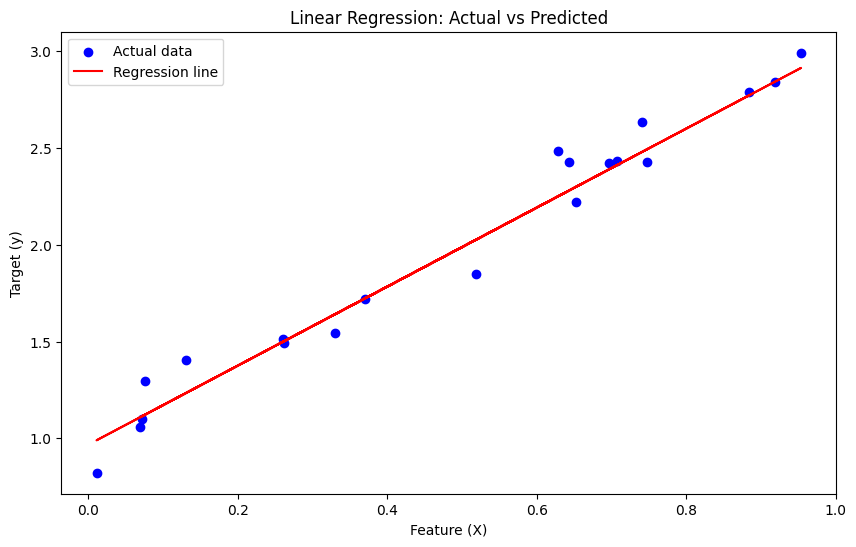

In [47]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Generate some random data (X: feature, y: target)
# For simplicity, let's use a synthetic dataset
X = np.random.rand(100, 1)  # 100 data points, 1 feature
y = 2 * X + 1 + np.random.randn(100, 1) * 0.1  # Linear relationship with some noise

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict the target values for the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Plot the results
plt.figure(figsize=(10, 6))

# Scatter plot of the actual data points
plt.scatter(X_test, y_test, color='blue', label='Actual data')

# Plot the predicted line
plt.plot(X_test, y_pred, color='red', label='Regression line')

plt.xlabel("Feature (X)")
plt.ylabel("Target (y)")
plt.title("Linear Regression: Actual vs Predicted")
plt.legend()
plt.show()


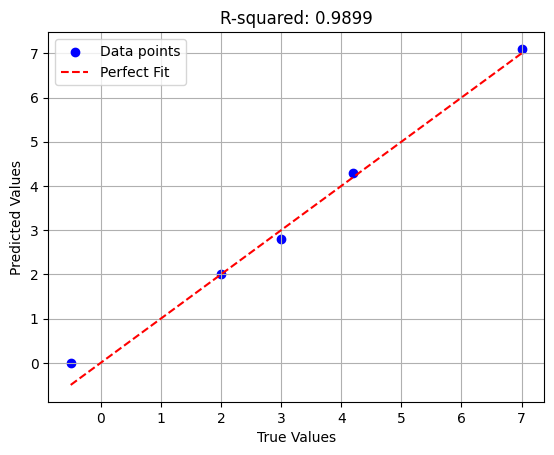

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Assuming y_true and y_pred are the true and predicted values respectively
y_true = np.array([3, -0.5, 2, 7, 4.2])  # Replace with actual true values
y_pred = np.array([2.8, 0.0, 2, 7.1, 4.3])  # Replace with your predicted values

# Calculate R-squared
r2 = r2_score(y_true, y_pred)

# Plotting the actual vs predicted values
plt.scatter(y_true, y_pred, color='blue', label='Data points')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'R-squared: {r2:.4f}')
plt.legend()
plt.grid(True)
plt.show()


Mean Squared Error (MSE): 0.01205348797529226
R-squared (R2): 0.9715608115292709


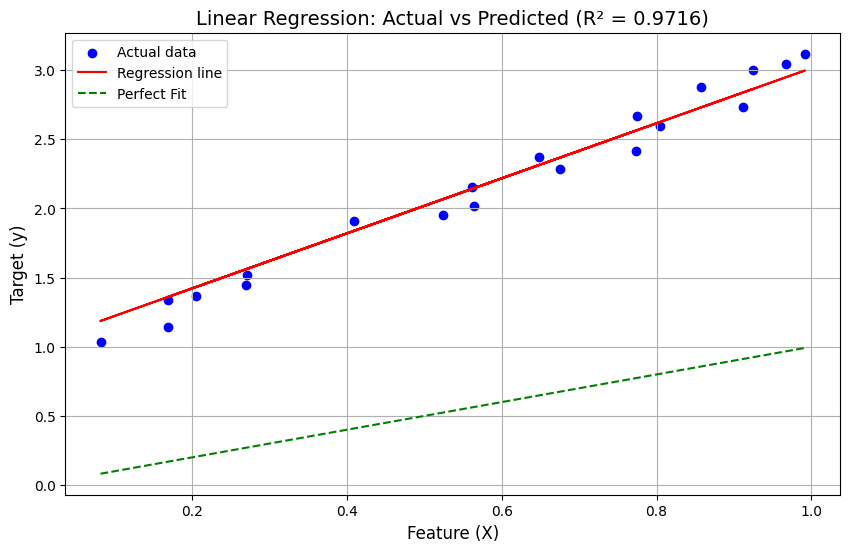

In [49]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Generate some random data (X: feature, y: target)
# For simplicity, let's use a synthetic dataset
X = np.random.rand(100, 1)  # 100 data points, 1 feature
y = 2 * X + 1 + np.random.randn(100, 1) * 0.1  # Linear relationship with some noise

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict the target values for the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Plot the results
plt.figure(figsize=(10, 6))

# Scatter plot of the actual data points
plt.scatter(X_test, y_test, color='blue', label='Actual data')

# Plot the predicted line
plt.plot(X_test, y_pred, color='red', label='Regression line')

# Plot a line representing the perfect fit (y = x) for comparison
plt.plot([min(X_test), max(X_test)], [min(X_test), max(X_test)], color='green', linestyle='--', label='Perfect Fit')

# Customize the plot with labels and title
plt.xlabel("Feature (X)", fontsize=12)
plt.ylabel("Target (y)", fontsize=12)
plt.title(f"Linear Regression: Actual vs Predicted (R² = {r2:.4f})", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


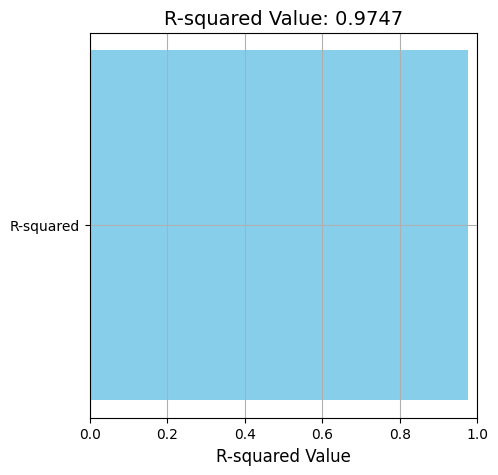

In [50]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Generate some random data (X: feature, y: target)
# For simplicity, let's use a synthetic dataset
X = np.random.rand(100, 1)  # 100 data points, 1 feature
y = 2 * X + 1 + np.random.randn(100, 1) * 0.1  # Linear relationship with some noise

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict the target values for the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
r2 = r2_score(y_test, y_pred)

# Plotting R-squared value
plt.figure(figsize=(5, 5))
plt.barh(['R-squared'], [r2], color='skyblue')
plt.xlabel('R-squared Value', fontsize=12)
plt.title(f'R-squared Value: {r2:.4f}', fontsize=14)
plt.xlim(0, 1)  # R-squared values range from 0 to 1
plt.grid(True)
plt.show()
